# Bike Lane Blockage Detection Model

This notebook implements a convolutional neural network (CNN) model to detect whether or not bike lanes are blocked. The model is trained on a dataset of images of bike lanes, some of which are blocked and some of which are not. The model is then evaluated on a test dataset to measure its accuracy. The notebook also includes code to visualize the training and testing metrics, such as the accuracy and loss of the model over time.

## Setup and Imports
Import required libraries and set up constants

In [1]:
!pip install tensorflow-macos tensorflow-metal numpy scikit-learn matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 27.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib
import platform
import time

In [18]:
# Constants used throughout the code
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64  # Increased batch size for faster processing
EPOCHS = 40     # Change back to higher after tests

## Image Loading and Preprocessing
Function to load and preprocess images from the dataset

In [89]:
def load_and_preprocess_images(directory, max_per_class=None):
    """
    Load and preprocess images with an optional limit per class.
    Args:
        directory: Base directory containing 'blocked' and 'notblocked' subdirectories
        max_per_class: Max number of images to load per class (if None, load all).  Used for testing.
    """
    
    # where I store the image files and their corresponding labels
    images = []
    labels = []
    
    print("\nLoading images with blocked bike lanes:")
    
    # Load blocked images
    blocked_dir = os.path.join(directory, 'blocked')
    blocked_files = [f for f in os.listdir(blocked_dir) if f.lower().endswith('.png')]
    if max_per_class:
        blocked_files = blocked_files[:max_per_class]
    
    for i, img_name in enumerate(blocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing blocked image {i}/{len(blocked_files)}")
        img_path = os.path.join(blocked_dir, img_name)
        # Load the image using Keras' load_img and then convert it to an array
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(1)  # 1 for blocked
    
    print("\nLoading images with unblocked bike lanes:")
    
    # Load not blocked images
    notblocked_dir = os.path.join(directory, 'notblocked')
    notblocked_files = [f for f in os.listdir(notblocked_dir) if f.lower().endswith('.png')]
    if max_per_class:
        notblocked_files = notblocked_files[:max_per_class]
    
    for i, img_name in enumerate(notblocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing non-blocked image {i}/{len(notblocked_files)}")
        img_path = os.path.join(notblocked_dir, img_name)
        # Load the image using Keras' load_img and then convert it to an array
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(0)  # 0 for not blocked
    
    return np.array(images), np.array(labels)

## Model Architecture
Define the CNN model architecture

In [73]:

def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Utility Functions
Helper functions for data preprocessing and GPU setup

In [74]:
def normalize_images(images):
    """Normalize image pixel values to [0,1] range."""
    return images.astype('float32') / 255.0

def split_dataset(images, labels, test_size=0.2, random_state=42):
    """Split dataset into training and testing sets."""
    return train_test_split(
        images, labels, test_size=test_size, random_state=random_state
    )

def setup_gpu():
    """Configure GPU settings for Metal acceleration."""
    tf.config.experimental.set_visible_devices(
        tf.config.list_physical_devices('GPU'),
        'GPU'
    )

## Training Functions
Functions for model training and evaluation

In [75]:
def train_model(model, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2):
    """Train the model and return training history."""
    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")
    print(f"Using {validation_split*100}% of training data for validation")
    
    class TrainingProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            print(f"\nEpoch {epoch + 1}/{epochs}")
        
        def on_batch_end(self, batch, logs=None):
            if batch % 5 == 0:  # Show progress every 5 batches
                print(".", end="", flush=True)
    
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[TrainingProgressCallback()],
        verbose=0
    )

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test data and return metrics."""
    print("\nEvaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"Evaluation complete!")
    return metrics

## Visualization Functions
Functions for plotting training history and printing system information

In [76]:
def plot_training_history(history):
    """Plot training and validation metrics."""
    print("\nGenerating training history plots...")
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    print("Displaying plots...")
    plt.show()

def print_versions():
    """Print versions of important packages."""
    print("\nPackage versions:")
    print(f"Python: {platform.python_version()}")
    print(f"TensorFlow: {tf.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"Scikit-learn: {sklearn.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    print(f"Keras: {tf.keras.__version__}")
    
    # Print GPU information if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("\nGPU Information:")
        for gpu in gpus:
            print(f"  {gpu}")
    print("\n")

## Running the complete training and testing pipeline


In [77]:
def run():
    # Print version information for the libraries
    print_versions()

    # 1. Load and preprocess images
    print("\n" + "="*50)
    print("Step 1: Loading and preprocessing images...")

    # load the images and preprocess them with Keras util functions. 
    # send the root folder that contains the blocked and notblocked 
    images, labels = load_and_preprocess_images('Bikelanes')  
    print("Normalizing images...")
    images = normalize_images(images)

    # 2. Split the dataset
    print("\n" + "="*50)
    print("Step 2: Splitting dataset into training and testing sets...")
    X_train, X_test, y_train, y_test = split_dataset(images, labels, test_size=0.2)

    print(f"\nDataset sizes:")
    print(f"Training images: {len(X_train)}")
    print(f"Testing images: {len(X_test)}")

    # 3. Create and compile the model
    print("\n" + "="*50)
    print("Step 3: Creating and compiling model...")
    model = create_model()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 4. Train the model
    print("\n" + "="*50)
    print("Step 4: Training model...")
    history = train_model(model, X_train, y_train)

    # 5. Evaluate the model
    print("\n" + "="*50)
    print("Step 5: Evaluating model...")
    metrics = evaluate_model(model, X_test, y_test)
    print(f"\nTest accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Test loss: {metrics['test_loss']:.4f}")

    # 6. Plot training history
    print("\n" + "="*50)
    print("Step 6: Plotting training history...")
    plot_training_history(history)

Overfitting is very obvious, but that's ok, we wanted to see if overfitting was even possible as we learned.

In [23]:
""" Now I'm going to add dropout to see if we can combat some of the overfitting. """

def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # higher dropout rate because it's a Dense
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model


Package versions:
Python: 3.11.6
TensorFlow: 2.16.2
NumPy: 1.26.2
Scikit-learn: 1.4.1.post1
Matplotlib: 3.8.3
Keras: 3.6.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/2186
Processing blocked image 50/2186
Processing blocked image 75/2186
Processing blocked image 100/2186
Processing blocked image 125/2186
Processing blocked image 150/2186
Processing blocked image 175/2186
Processing blocked image 200/2186
Processing blocked image 225/2186
Processing blocked image 250/2186
Processing blocked image 275/2186
Processing blocked image 300/2186
Processing blocked image 325/2186
Processing blocked image 350/2186
Processing blocked image 375/2186
Processing blocked image 400/2186
Processing blocked image 425/2186
Processing blocked image 450/2186
Processing blocked image 475/2186
Processing blocked image 500/2186
Processing blocked image 5

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/40
........
Epoch 2/40
........
Epoch 3/40
........
Epoch 4/40
........
Epoch 5/40
........
Epoch 6/40
........
Epoch 7/40
........
Epoch 8/40
........
Epoch 9/40
........
Epoch 10/40
........
Epoch 11/40
........
Epoch 12/40
........
Epoch 13/40
........
Epoch 14/40
........
Epoch 15/40
........
Epoch 16/40
........
Epoch 17/40
........
Epoch 18/40
........
Epoch 19/40
........
Epoch 20/40
........
Epoch 21/40
........
Epoch 22/40
........
Epoch 23/40
........
Epoch 24/40
........
Epoch 25/40
........
Epoch 26/40
........
Epoch 27/40
........
Epoch 28/40
........
Epoch 29/40
........
Epoch 30/40
........
Epoch 31/40
........
Epoch 32/40
........
Epoch 33/40
........
Epoch 34/40
........
Epoch 35/40
........
Epoch 36/40
........
Epoch 37/40
........
Epoch 38/40
........
Epoch 39/40
........
Epoch 40/40
........
Step 5: Evaluating model...

Evaluating model on test data...
Evaluation complete!

Test accuracy: 0.8583
Test loss: 0.7525

Step 6: Plotting training history...

Gener

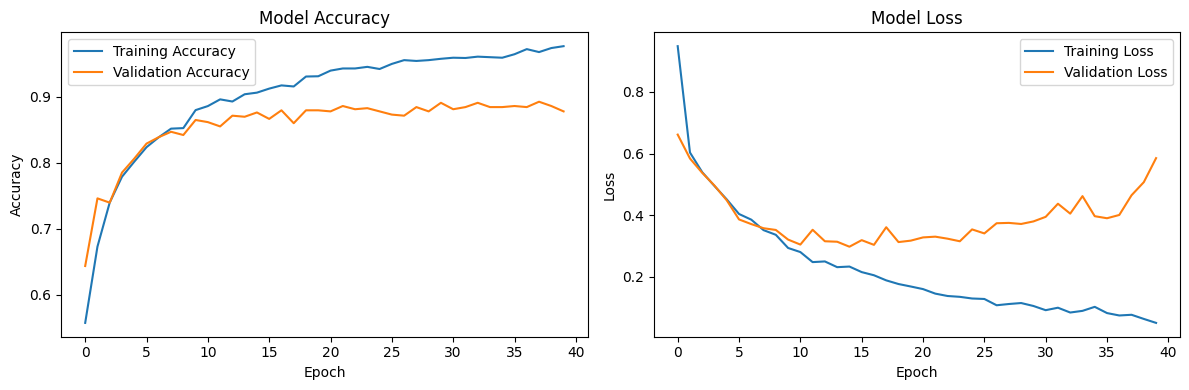

In [24]:
# Print version information for the libraries
print_versions()

# 1. Load and preprocess images
print("\n" + "="*50)
print("Step 1: Loading and preprocessing images...")

# load the images and preprocess them with Keras util functions. 
# send the root folder that contains the blocked and notblocked 
images, labels = load_and_preprocess_images('Bikelanes')  
print("Normalizing images...")
images = normalize_images(images)

# 2. Split the dataset
print("\n" + "="*50)
print("Step 2: Splitting dataset into training and testing sets...")
X_train, X_test, y_train, y_test = split_dataset(images, labels, test_size=0.2)

print(f"\nDataset sizes:")
print(f"Training images: {len(X_train)}")
print(f"Testing images: {len(X_test)}")

# 3. Create and compile the model
print("\n" + "="*50)
print("Step 3: Creating and compiling model...")
model = create_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Train the model
print("\n" + "="*50)
print("Step 4: Training model...")
history = train_model(model, X_train, y_train)

# 5. Evaluate the model
print("\n" + "="*50)
print("Step 5: Evaluating model...")
metrics = evaluate_model(model, X_test, y_test)
print(f"\nTest accuracy: {metrics['test_accuracy']:.4f}")
print(f"Test loss: {metrics['test_loss']:.4f}")

# 6. Plot training history
print("\n" + "="*50)
print("Step 6: Plotting training history...")
plot_training_history(history)

Slight improvement, but still not great. I'm going to add dropout right at the input stage and increase rates across the board.


In [78]:
def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        #initial dropout
        layers.Dropout(0.5),


        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model


Package versions:
Python: 3.11.6
TensorFlow: 2.16.2
NumPy: 1.26.2
Scikit-learn: 1.4.1.post1
Matplotlib: 3.8.3
Keras: 3.6.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/2186
Processing blocked image 50/2186
Processing blocked image 75/2186
Processing blocked image 100/2186
Processing blocked image 125/2186
Processing blocked image 150/2186
Processing blocked image 175/2186
Processing blocked image 200/2186
Processing blocked image 225/2186
Processing blocked image 250/2186
Processing blocked image 275/2186
Processing blocked image 300/2186
Processing blocked image 325/2186
Processing blocked image 350/2186
Processing blocked image 375/2186
Processing blocked image 400/2186
Processing blocked image 425/2186
Processing blocked image 450/2186
Processing blocked image 475/2186
Processing blocked image 500/2186
Processing blocked image 5

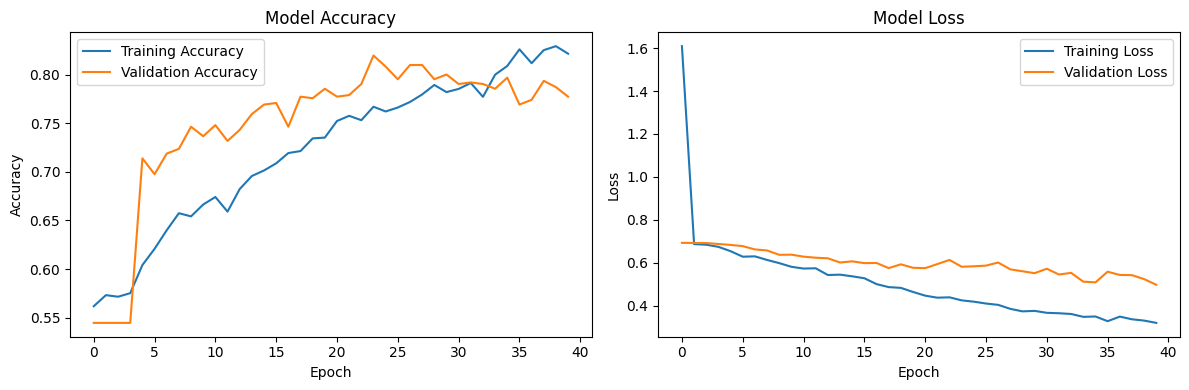

In [79]:
run()

That was much worse. I think too much dropout, so I'll try just input dropout and compare it to the one before last.

In [28]:
def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        #initial dropout
        layers.Dropout(0.5),


        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        #layers.Dropout(0.5),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        #layers.Dropout(0.5),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        #layers.Dropout(0.5),
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model



Package versions:
Python: 3.11.6
TensorFlow: 2.16.2
NumPy: 1.26.2
Scikit-learn: 1.4.1.post1
Matplotlib: 3.8.3
Keras: 3.6.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/2186
Processing blocked image 50/2186
Processing blocked image 75/2186
Processing blocked image 100/2186
Processing blocked image 125/2186
Processing blocked image 150/2186
Processing blocked image 175/2186
Processing blocked image 200/2186
Processing blocked image 225/2186
Processing blocked image 250/2186
Processing blocked image 275/2186
Processing blocked image 300/2186
Processing blocked image 325/2186
Processing blocked image 350/2186
Processing blocked image 375/2186
Processing blocked image 400/2186
Processing blocked image 425/2186
Processing blocked image 450/2186
Processing blocked image 475/2186
Processing blocked image 500/2186
Processing blocked image 5

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/40
........
Epoch 2/40
........
Epoch 3/40
........
Epoch 4/40
........
Epoch 5/40
........
Epoch 6/40
........
Epoch 7/40
........
Epoch 8/40
........
Epoch 9/40
........
Epoch 10/40
........
Epoch 11/40
........
Epoch 12/40
........
Epoch 13/40
........
Epoch 14/40
........
Epoch 15/40
........
Epoch 16/40
........
Epoch 17/40
........
Epoch 18/40
........
Epoch 19/40
........
Epoch 20/40
........
Epoch 21/40
........
Epoch 22/40
........
Epoch 23/40
........
Epoch 24/40
........
Epoch 25/40
........
Epoch 26/40
........
Epoch 27/40
........
Epoch 28/40
........
Epoch 29/40
........
Epoch 30/40
........
Epoch 31/40
........
Epoch 32/40
........
Epoch 33/40
........
Epoch 34/40
........
Epoch 35/40
........
Epoch 36/40
........
Epoch 37/40
........
Epoch 38/40
........
Epoch 39/40
........
Epoch 40/40
........
Step 5: Evaluating model...

Evaluating model on test data...
Evaluation complete!

Test accuracy: 0.8270
Test loss: 0.4379

Step 6: Plotting training history...

Gener

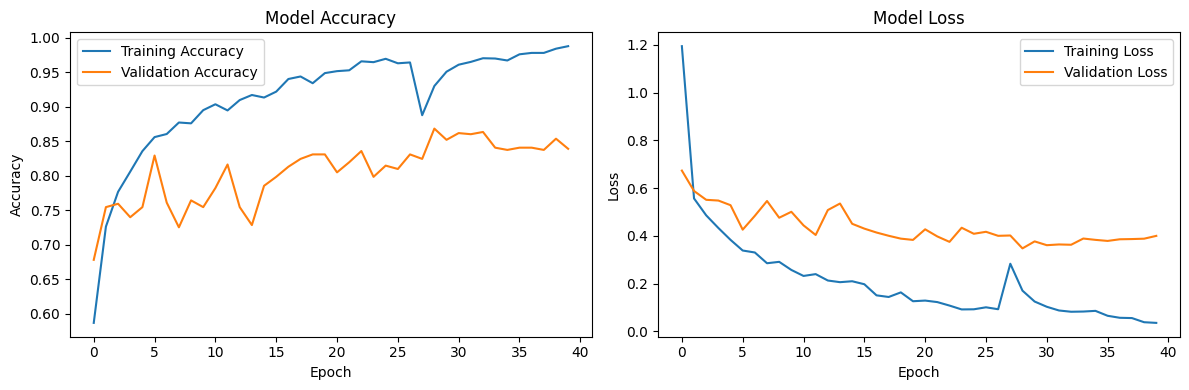

In [29]:
run()

That was also worse, so we'll revert to the best of the dropout trials.
Also, it looks like for the better performing models, 10 epochs is the point that overfitting starts to occur.
So, I'm going to implement early stopping instead of just relying on hard-coded epochs.

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=5,              # Number of epochs to wait before stopping
    min_delta=0.01,          # Minimum change in the monitored metric to qualify as an improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

In [81]:
def train_model(model, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2):
    """Train the model and return training history."""
    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")
    print(f"Using {validation_split*100}% of training data for validation")
    
    class TrainingProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            print(f"\nEpoch {epoch + 1}/{epochs}")
        
        def on_batch_end(self, batch, logs=None):
            if batch % 5 == 0:  # Show progress every 5 batches
                print(".", end="", flush=True)
    
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[TrainingProgressCallback(), early_stopping], # ADDED EARLY STOPPING
        verbose=0
    )

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test data and return metrics."""
    print("\nEvaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"Evaluation complete!")
    return metrics

I'm going to re-run with the best dropout we tested and early stopping. I'm also going to add another Conv2D layer to try to increase accuracy.

In [82]:
def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Fourth Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # higher dropout rate because it's a Dense
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model


Package versions:
Python: 3.11.6
TensorFlow: 2.16.2
NumPy: 1.26.2
Scikit-learn: 1.4.1.post1
Matplotlib: 3.8.3
Keras: 3.6.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/2186
Processing blocked image 50/2186
Processing blocked image 75/2186
Processing blocked image 100/2186
Processing blocked image 125/2186
Processing blocked image 150/2186
Processing blocked image 175/2186
Processing blocked image 200/2186
Processing blocked image 225/2186
Processing blocked image 250/2186
Processing blocked image 275/2186
Processing blocked image 300/2186
Processing blocked image 325/2186
Processing blocked image 350/2186
Processing blocked image 375/2186
Processing blocked image 400/2186
Processing blocked image 425/2186
Processing blocked image 450/2186
Processing blocked image 475/2186
Processing blocked image 500/2186
Processing blocked image 5

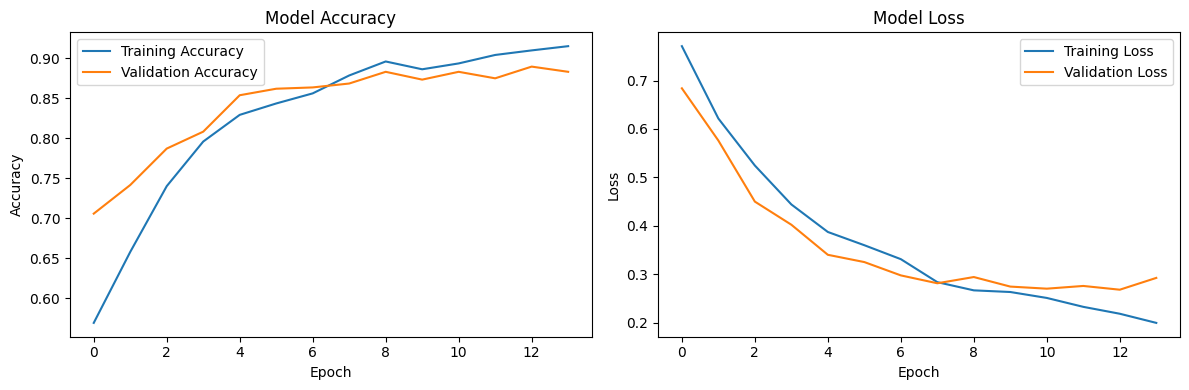

In [83]:
run()

We gathered data from volunteers online (mostly Reddit) that contains FPV bike footage. We are going to try to find examples of cars in the bike lane and label them.

We used the yt-dlp package to download MP4 files from YouTube links.

Then, we used this code to split the videos into frames.

In [ ]:
import cv2

def extract_frames(video_path, output_folder, frame_rate=1):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps / frame_rate)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            cv2.imwrite(f"{output_folder}/frame_{frame_count}.jpg", frame)
        frame_count += 1

    cap.release()

extract_frames("UnknownLocation.mp4", "UnknownLocation", frame_rate=1)
extract_frames("UofI.mp4", "UofI/", frame_rate=1)
extract_frames("RainyPhilly.mp4", "RainyPhilly/", frame_rate=1)
extract_frames("Chicago.mp4", "Chicago/", frame_rate=1)  # One frame per second

In [ ]:
"""IDENTIFYING RANGES OF FRAMES WITH POSITIVE CASES"""
UnknownLocationList = [(1980, 2940), (27780, 27840)]
UofIList = [()] # literally has no positive cases
PhillyRainyList = [(6808, 6900),(8188, 8211)]
ChicagoList = [(900, 1020),(4800,4980),(6060, 6150), (7560,7650)]

# it's actually easier to separate these manually into two different folders like the initial dataset

In [91]:
model = create_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Train the model
print("\n" + "="*50)
print("Step 4: Training model...")
history = train_model(model, X_train, y_train)



Step 4: Training model...

Training with 40 epochs, batch size 64
Using 20.0% of training data for validation

Epoch 1/40
........
Epoch 2/40
........
Epoch 3/40
........
Epoch 4/40
........
Epoch 5/40
........

As you can see, the accuracy is basically the same as randomly guessing (classes are evenly balanced).
This was to be expected considering how radically different the perspectives are.
So let's try training a model on our data even though we don't have a lot at all.

In [ ]:
"""Optimally our model should predict 1 for all frames in the BLOCKED_NEW folder and vice versa. Let's try."""


def load_and_preprocess_images(directory, max_per_class=None): # have to make edits to work with new frames
    """
    Load and preprocess images with an optional limit per class.
    Args:
        directory: Base directory containing 'blocked' and 'notblocked' subdirectories
        max_per_class: Max number of images to load per class (if None, load all).  Used for testing.
    """
    
    # where I store the image files and their corresponding labels
    images = []
    labels = []
    
    print("\nLoading images with blocked bike lanes:")
    
    # Load blocked images
    blocked_dir = os.path.join(directory, 'BLOCKED_NEW')
    blocked_files = [f for f in os.listdir(blocked_dir) if f.lower().endswith('.jpg')]
    if max_per_class:
        blocked_files = blocked_files[:max_per_class]
    
    for i, img_name in enumerate(blocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing blocked image {i}/{len(blocked_files)}")
        img_path = os.path.join(blocked_dir, img_name)
        # Load the image using Keras' load_img and then convert it to an array
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(1)  # 1 for blocked
    
    print("\nLoading images with unblocked bike lanes:")
    
    # Load not blocked images
    notblocked_dir = os.path.join(directory, 'UNBLOCKED_NEW')
    notblocked_files = [f for f in os.listdir(notblocked_dir) if f.lower().endswith('.jpg')]
    if max_per_class:
        notblocked_files = notblocked_files[:max_per_class]
    
    for i, img_name in enumerate(notblocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing non-blocked image {i}/{len(notblocked_files)}")
        img_path = os.path.join(notblocked_dir, img_name)
        # Load the image using Keras' load_img and then convert it to an array
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(0)  # 0 for not blocked
    
    return np.array(images), np.array(labels)

In [93]:

images, labels = load_and_preprocess_images('NEW')
images = normalize_images(images)
print(images)
print(labels)
model.evaluate(images, labels)


Loading images with blocked bike lanes:
Processing blocked image 25/46

Loading images with unblocked bike lanes:
Processing non-blocked image 25/46
[[[[    0.20392     0.20784     0.17647]
   [    0.28235     0.28235     0.25098]
   [    0.27451     0.27843     0.24706]
   ...
   [    0.43529      0.4549     0.43922]
   [    0.43137     0.44706     0.45098]
   [    0.41961     0.43137     0.45098]]

  [[    0.20784     0.21176     0.18039]
   [    0.27059     0.26667     0.25098]
   [    0.25098      0.2549     0.23529]
   ...
   [     0.4549     0.47059     0.46667]
   [    0.42745     0.44314     0.44706]
   [    0.43529     0.44706     0.47451]]

  [[    0.20392         0.2     0.18039]
   [    0.27451     0.27059      0.2549]
   [    0.21961     0.21961     0.21176]
   ...
   [    0.47059     0.48627     0.48235]
   [    0.51373     0.52941     0.52549]
   [    0.45098     0.46667     0.47059]]

  ...

  [[    0.21569     0.22353     0.18039]
   [        0.2     0.19608     0.180

[0.6929100751876831, 0.5]

In [115]:
def run():
    # Print version information for the libraries
    print_versions()

    # 1. Load and preprocess images
    print("\n" + "="*50)
    print("Step 1: Loading and preprocessing images...")

    # load the images and preprocess them with Keras util functions. 
    # send the root folder that contains the blocked and notblocked 
    images, labels = load_and_preprocess_images('NEW')  
    print("Normalizing images...")
    images = normalize_images(images)

    # 2. Split the dataset
    print("\n" + "="*50)
    print("Step 2: Splitting dataset into training and testing sets...")
    X_train, X_test, y_train, y_test = split_dataset(images, labels, test_size=0.2)

    print(f"\nDataset sizes:")
    print(f"Training images: {len(X_train)}")
    print(f"Testing images: {len(X_test)}")

    # 3. Create and compile the model
    print("\n" + "="*50)
    print("Step 3: Creating and compiling model...")
    model = create_model()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 4. Train the model
    print("\n" + "="*50)
    print("Step 4: Training model...")
    history = train_model(model, X_train, y_train)

    # 5. Evaluate the model
    print("\n" + "="*50)
    print("Step 5: Evaluating model...")
    metrics = evaluate_model(model, X_test, y_test)
    print(f"\nTest accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Test loss: {metrics['test_loss']:.4f}")

    # 6. Plot training history
    print("\n" + "="*50)
    print("Step 6: Plotting training history...")
    plot_training_history(history)


Package versions:
Python: 3.11.6
TensorFlow: 2.16.2
NumPy: 1.26.2
Scikit-learn: 1.4.1.post1
Matplotlib: 3.8.3
Keras: 3.6.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/46

Loading images with unblocked bike lanes:
Processing non-blocked image 25/46
Normalizing images...

Step 2: Splitting dataset into training and testing sets...

Dataset sizes:
Training images: 73
Testing images: 19

Step 3: Creating and compiling model...

Step 4: Training model...

Training with 40 epochs, batch size 64
Using 20.0% of training data for validation

Epoch 1/40


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


.
Epoch 2/40
.
Epoch 3/40
.
Epoch 4/40
.
Epoch 5/40
.
Step 5: Evaluating model...

Evaluating model on test data...
Evaluation complete!

Test accuracy: 0.3684
Test loss: 6.3549

Step 6: Plotting training history...

Generating training history plots...
Displaying plots...


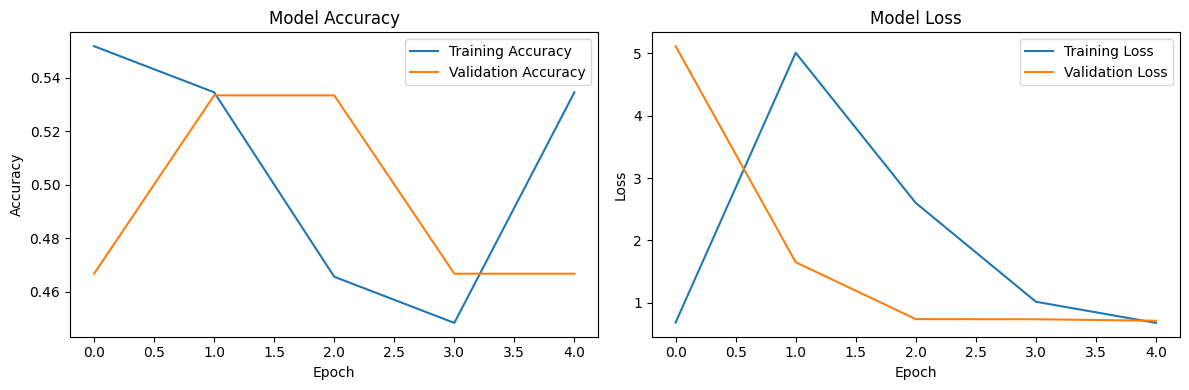

In [50]:
run()

Pretty terrible results. It's nowhere near enough data. I will try adding augmentation.


Package versions:
Python: 3.11.6
TensorFlow: 2.16.2
NumPy: 1.26.2
Scikit-learn: 1.4.1.post1
Matplotlib: 3.8.3
Keras: 3.6.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/46

Loading images with unblocked bike lanes:
Processing non-blocked image 25/46
Normalizing images...

Step 2: Splitting dataset into training and testing sets...

Dataset sizes:
Training images: 73
Testing images: 19

Step 3: Creating and compiling model...

Step 4: Training model...

Training with 40 epochs, batch size 64
Using 20.0% of training data for validation

Epoch 1/40


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


.
Epoch 2/40
.
Epoch 3/40
.
Epoch 4/40
.
Epoch 5/40
.
Step 5: Evaluating model...

Evaluating model on test data...
Evaluation complete!

Test accuracy: 0.3684
Test loss: 3.5219

Step 6: Plotting training history...

Generating training history plots...
Displaying plots...


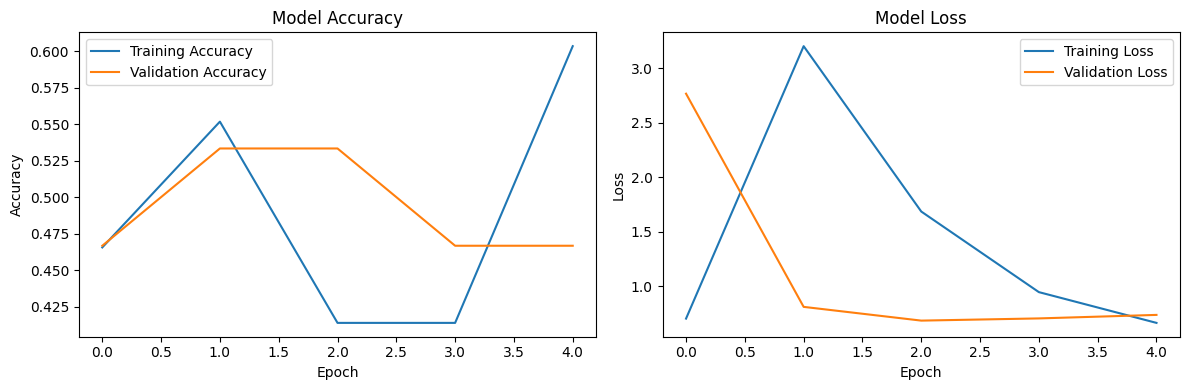

In [52]:
def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.RandomRotation(0.1, fill_mode='wrap'),
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Fourth Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # higher dropout rate because it's a Dense
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model
run()

Still pretty bad. I just don't think there's enough data.

In [55]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  # Use 'yolov8n' for nano model, or fine-tune on your dataset


In [59]:
results = model('NEW/BLOCKED_NEW/frame_2040.jpg')

# Parse results
for result in results:
    boxes = result.boxes.xyxy  # Bounding box coordinates
    confidences = result.boxes.conf  # Confidence scores
    classes = result.boxes.cls  # Class IDs (e.g., car, bike lane)

    # Example: Check for overlap between car and bike lane boxes
    #car_boxes = boxes[classes == CAR_CLASS_ID]
    #bike_lane_boxes = boxes[classes == BIKE_LANE_CLASS_ID]
    print(boxes)
    print(confidences)
    print(classes)


image 1/1 /Users/henrywillis/Downloads/DS340_FP/NEW/BLOCKED_NEW/frame_2040.jpg: 384x640 10 cars, 2 trucks, 86.9ms
Speed: 2.9ms preprocess, 86.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
tensor([[1491.6851,  428.9137, 1919.5031,  895.6540],
        [  28.8071,  482.8659,  513.7964,  728.1200],
        [ 503.3550,  553.3950,  635.7514,  638.6151],
        [1008.7739,  443.9892, 1131.6379,  611.4955],
        [1101.9143,  496.1895, 1317.3549,  658.7036],
        [ 964.9774,  558.6437, 1010.2372,  596.5878],
        [ 605.5661,  551.3289,  690.7565,  625.2559],
        [ 679.8771,  560.5197,  754.8988,  619.3496],
        [ 841.6069,  566.0146,  916.6113,  600.7263],
        [ 823.5505,  563.2188,  906.9174,  601.3510],
        [ 501.6312,  556.0383,  586.5673,  640.6538],
        [ 631.2150,  552.6458,  753.6721,  623.1105]])
tensor([0.8955, 0.8950, 0.6336, 0.6282, 0.5999, 0.5132, 0.4129, 0.4032, 0.3485, 0.2820, 0.2705, 0.2696])
tensor([2., 2., 2., 7., 7., 2., 2.

It did not detect the bike lanes, but it did get cars and trucks.
However, the confidence is too low, I imagine because the perspective is so different.
I will annotate my own images and refine a model.

In [99]:
from roboflow import Roboflow
rf = Roboflow(api_key="wqJzouyGmLTtNFQwEXfu")
project = rf.workspace().project("ds340_bikelanes")
model = project.version(1).model

# infer on a local image
preds = model.predict("NEW/BLOCKED_NEW/frame_2520.jpg", confidence=40, overlap=30).json()
predictions = preds['predictions']
coordinates = [(item['x'], item['y'], item['height']) for item in predictions]

# Print the result
print(coordinates)


loading Roboflow workspace...
loading Roboflow project...
[(1479, 606, 177), (1035, 581, 72), (328, 616, 200), (529, 615, 111), (619, 597, 114), (1128, 575, 67), (757, 594, 74), (103, 631, 293), (835, 588, 40), (930, 583, 38)]


In [111]:
"""I need to pull the X,Y,H coordinates out and use those as the training data."""

"""Optimally our model should predict 1 for all frames in the BLOCKED_NEW folder and vice versa. Let's try."""


def load_and_preprocess_images(directory, max_per_class=None): # have to make edits to work with new frames
    """
    Load and preprocess images with an optional limit per class.
    Args:
        directory: Base directory containing 'blocked' and 'notblocked' subdirectories
        max_per_class: Max number of images to load per class (if None, load all).  Used for testing.
    """
    
    # where I store the image files and their corresponding labels
    images = []
    labels = []
    
    print("\nLoading images with blocked bike lanes:")
    
    # Load blocked images
    blocked_dir = os.path.join(directory, 'BLOCKED_NEW')
    blocked_files = [f for f in os.listdir(blocked_dir) if f.lower().endswith('.jpg')]
    if max_per_class:
        blocked_files = blocked_files[:max_per_class]
    
    for i, img_name in enumerate(blocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing blocked image {i}/{len(blocked_files)}")
        img_path = os.path.join(blocked_dir, img_name)
        # Load the image using Keras' load_img and then convert it to an array

        preds = model.predict(img_path, confidence=40, overlap=30).json()
        predictions = preds['predictions']
        coordinates = [(item['x'], item['y'], item['height']) for item in predictions]

        images.append(coordinates)
        labels.append(1)  # 1 for blocked
    
    print("\nLoading images with unblocked bike lanes:")
    
    # Load not blocked images
    notblocked_dir = os.path.join(directory, 'UNBLOCKED_NEW')
    notblocked_files = [f for f in os.listdir(notblocked_dir) if f.lower().endswith('.jpg')]
    if max_per_class:
        notblocked_files = notblocked_files[:max_per_class]
    
    for i, img_name in enumerate(notblocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing non-blocked image {i}/{len(notblocked_files)}")
        img_path = os.path.join(notblocked_dir, img_name)
        preds = model.predict(img_path, confidence=40, overlap=30).json()
        predictions = preds['predictions']
        coordinates = [(item['x'], item['y'], item['height']) for item in predictions]

        images.append(coordinates)
        labels.append(0)  # 0 for not blocked
    
    from itertools import zip_longest
    max_length = max(len(inner) for inner in images)

    # Pad each inner list with (0, 0, 0) to match the maximum length
    padded_data = [inner + [(0, 0, 0)] * (max_length - len(inner)) for inner in images]
        
    return np.array(padded_data), np.array(labels)

In [117]:
"""Need to update NN structure to accomodate the new feature dimensions."""
images, labels = load_and_preprocess_images("NEW")


Loading images with blocked bike lanes:
Processing blocked image 25/46

Loading images with unblocked bike lanes:
Processing non-blocked image 25/46


In [130]:
def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.RandomRotation(0.1, fill_mode='wrap'),
        layers.Conv1D(32, 1, activation='relu', input_shape=(10, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling1D(2),
        layers.Dropout(0.25),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv1D(32, 1, activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling1D(2),
        layers.Dropout(0.25),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv1D(32,1, activation='relu'),

        # Fourth Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv1D(32,1, activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # higher dropout rate because it's a Dense
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [141]:
"""GETTING RID OF EARLY STOPPING
ALSO ADDING MORE EPOCHS CUZ IT'S WAY FASTER"""

def train_model(model, X_train, y_train, epochs=100, batch_size=BATCH_SIZE, validation_split=0.2):
    """Train the model and return training history."""
    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")
    print(f"Using {validation_split*100}% of training data for validation")
    
    class TrainingProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            print(f"\nEpoch {epoch + 1}/{epochs}")
        
        def on_batch_end(self, batch, logs=None):
            if batch % 5 == 0:  # Show progress every 5 batches
                print(".", end="", flush=True)
    
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[TrainingProgressCallback()],
        verbose=0
    )

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test data and return metrics."""
    print("\nEvaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"Evaluation complete!")
    return metrics


Dataset sizes:
Training images: 73
Testing images: 19

Step 3: Creating and compiling model...

Step 4: Training model...

Training with 100 epochs, batch size 64
Using 20.0% of training data for validation

Epoch 1/100


.
Epoch 2/100
.
Epoch 3/100
.
Epoch 4/100
.
Epoch 5/100
.
Epoch 6/100
.
Epoch 7/100
.
Epoch 8/100
.
Epoch 9/100
.
Epoch 10/100
.
Epoch 11/100
.
Epoch 12/100
.
Epoch 13/100
.
Epoch 14/100
.
Epoch 15/100
.
Epoch 16/100
.
Epoch 17/100
.
Epoch 18/100
.
Epoch 19/100
.
Epoch 20/100
.
Epoch 21/100
.
Epoch 22/100
.
Epoch 23/100
.
Epoch 24/100
.
Epoch 25/100
.
Epoch 26/100
.
Epoch 27/100
.
Epoch 28/100
.
Epoch 29/100
.
Epoch 30/100
.
Epoch 31/100
.
Epoch 32/100
.
Epoch 33/100
.
Epoch 34/100
.
Epoch 35/100
.
Epoch 36/100
.
Epoch 37/100
.
Epoch 38/100
.
Epoch 39/100
.
Epoch 40/100
.
Epoch 41/100
.
Epoch 42/100
.
Epoch 43/100
.
Epoch 44/100
.
Epoch 45/100
.
Epoch 46/100
.
Epoch 47/100
.
Epoch 48/100
.
Epoch 49/100
.
Epoch 50/100
.
Epoch 51/100
.
Epoch 52/100
.
Epoch 53/100
.
Epoch 54/100
.
Epoch 55/100
.
Epoch 56/100
.
Epoch 57/100
.
Epoch 58/100
.
Epoch 59/100
.
Epoch 60/100
.
Epoch 61/100
.
Epoch 62/100
.
Epoch 63/100
.
Epoch 64/100
.
Epoch 65/100
.
Epoch 66/100
.
Epoch 67/100
.
Epoch 68/100
.
E

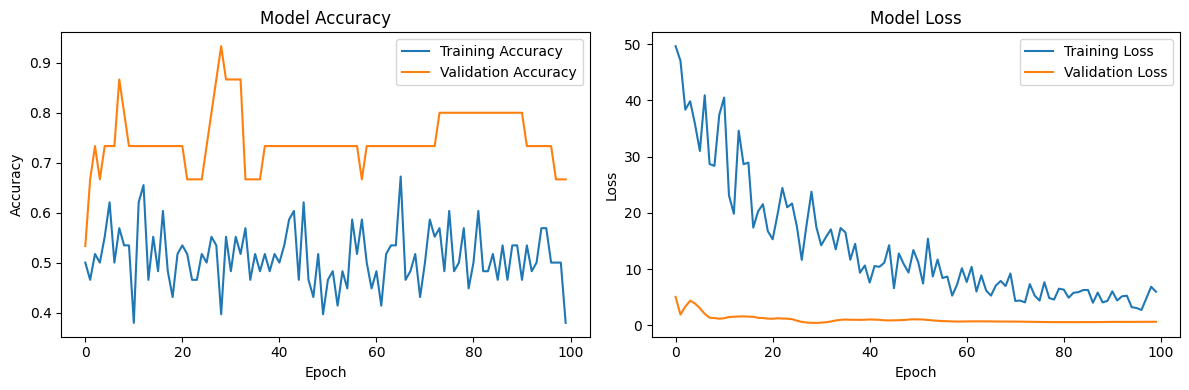

In [142]:
X_train, X_test, y_train, y_test = split_dataset(images, labels, test_size=0.2)

print(f"\nDataset sizes:")
print(f"Training images: {len(X_train)}")
print(f"Testing images: {len(X_test)}")

# 3. Create and compile the model
print("\n" + "="*50)
print("Step 3: Creating and compiling model...")
model = create_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Train the model
print("\n" + "="*50)
print("Step 4: Training model...")
history = train_model(model, X_train, y_train)

# 5. Evaluate the model
print("\n" + "="*50)
print("Step 5: Evaluating model...")
metrics = evaluate_model(model, X_test, y_test)
print(f"\nTest accuracy: {metrics['test_accuracy']:.4f}")
print(f"Test loss: {metrics['test_loss']:.4f}")

# 6. Plot training history
print("\n" + "="*50)
print("Step 6: Plotting training history...")
plot_training_history(history)

In [148]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)
svm_model = SVC(kernel='rbf', random_state=340)  # 'rbf' kernel often works well for non-linear data
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7895

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.83      0.83      0.83        12

    accuracy                           0.79        19
   macro avg       0.77      0.77      0.77        19
weighted avg       0.79      0.79      0.79        19


Confusion Matrix:
[[ 5  2]
 [ 2 10]]
